# Getting data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# exploring pkl file for data

As i am not sure about what kind of data it is.

as the shape of data[0] = 784, 
as it is a image data 784 =28x28x1 should be the shape of image

In [2]:
import os

data_path = '/content/drive/My Drive/Vision_task_dataset_public/'

os.listdir(data_path)


['train_label.pkl',
 'train_image.pkl',
 'test_image.pkl',
 'hitkul(sample_submission).csv']

In [3]:
import pickle


with open(data_path + 'train_image.pkl', 'rb') as f:
    data = pickle.load(f)
    print(len(data[0]))

784


In [4]:
len(data)

8000

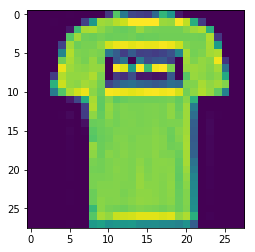

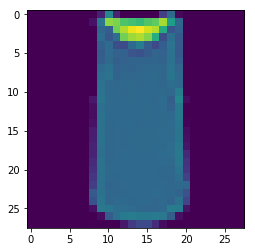

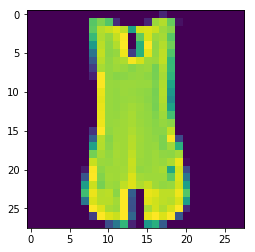

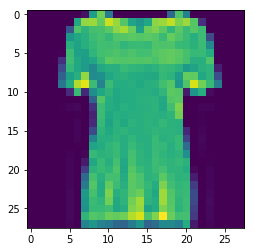

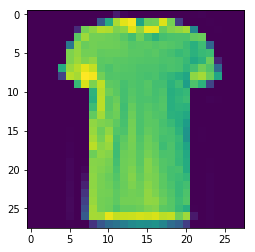

In [5]:
import numpy as np
import matplotlib.pyplot as plt


for i in range(5):
  reshaped_data = np.array(data[i]).reshape(28,28)
  plt.imshow(reshaped_data)
  plt.grid(False)
  plt.show()

# Getting Image and labels as numpy arrays

In [6]:
os.listdir(data_path)

['train_label.pkl',
 'train_image.pkl',
 'test_image.pkl',
 'hitkul(sample_submission).csv']

### Train_image

In [7]:
import pickle


with open(data_path + 'train_image.pkl', 'rb') as f:
    data = pickle.load(f)

train_img = np.stack([np.array(i).reshape(1,28,28) for i in data])
print(train_img.shape)

(8000, 1, 28, 28)


### test image

In [8]:
import pickle


with open(data_path + 'test_image.pkl', 'rb') as f:
    data = pickle.load(f)

test_img = np.stack([np.array(i).reshape(1, 28,28) for i in data])
print(test_img.shape)

(2000, 1, 28, 28)


### train_label

In [9]:
import pickle


with open(data_path + 'train_label.pkl', 'rb') as f:
    data = pickle.load(f)

set(data)

{0, 2, 3, 6}

In [10]:
from collections import Counter

Counter(data)

Counter({0: 2000, 2: 2000, 3: 2000, 6: 2000})

Reindexing 0-0 , 2-1, 3-2, 6-3  for computation index purpose

In [11]:
train_label = np.array(data)

train_label[train_label == 2] = 1
train_label[train_label == 3] = 2
train_label[train_label == 6] = 3

set(list(train_label))


{0, 1, 2, 3}

### Sample Submission

In [12]:
import pandas as pd

df = pd.read_csv(data_path+'hitkul(sample_submission).csv')
df.head(10)

,image_index,class
0,0,2
1,1,3
2,2,0
3,3,6


# Visualizing Data

Label =  0


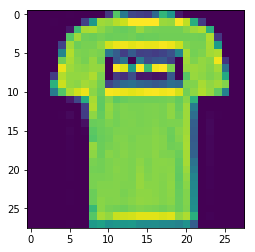

Label =  0


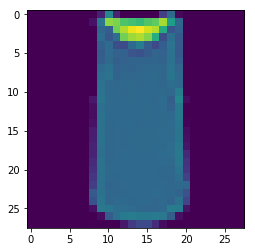

Label =  0


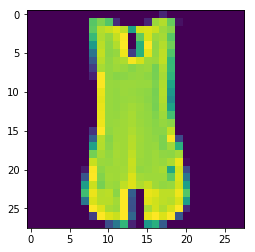

Label =  0


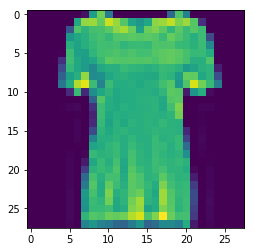

Label =  0


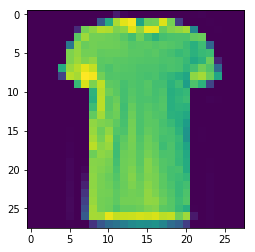

In [13]:
for i in range(5):
  print('Label = ',train_label[i])
  plt.imshow(train_img[i,:,:].reshape(28,28))
  plt.show()
  

Label =  1


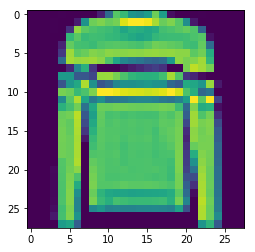

Label =  1


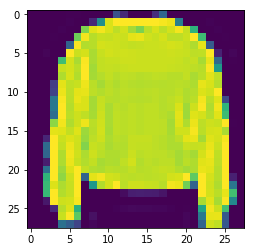

Label =  1


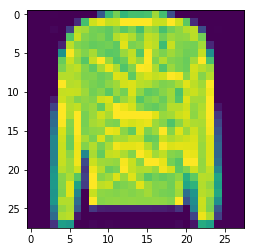

Label =  1


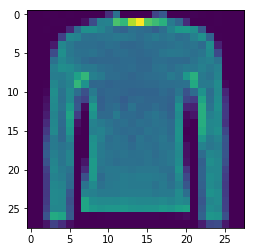

Label =  1


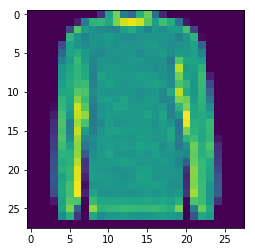

In [14]:
for i in range(2000,2005):
  print('Label = ',train_label[i])
  plt.imshow(train_img[i,:,:].reshape(28,28))
  plt.show()
  

Label =  2


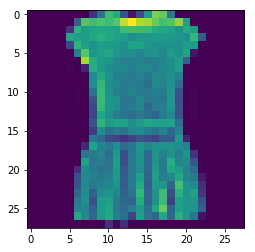

Label =  2


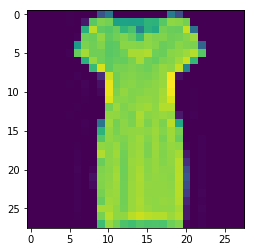

Label =  2


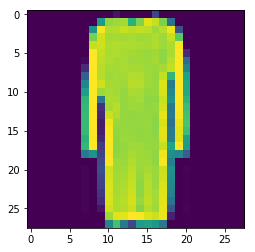

Label =  2


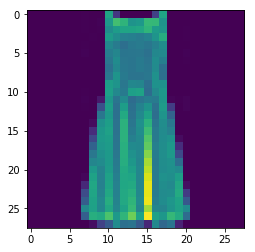

Label =  2


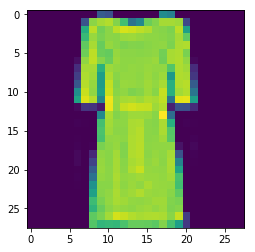

In [15]:
for i in range(4000,4005):
  print('Label = ',train_label[i])
  plt.imshow(train_img[i,:,:].reshape(28,28))
  plt.show()
  

Label =  3


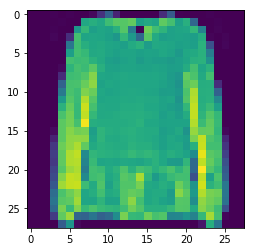

Label =  3


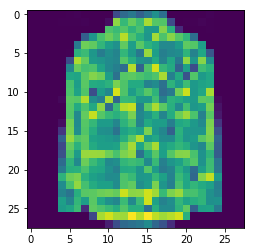

Label =  3


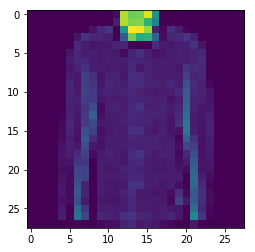

Label =  3


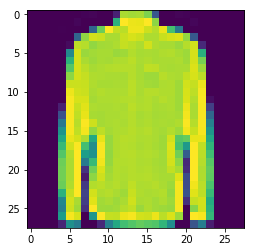

Label =  3


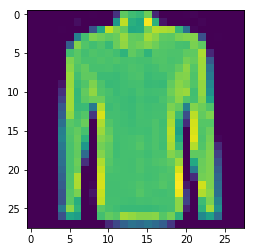

In [16]:
for i in range(6000,6005):
  print('Label = ',train_label[i])
  plt.imshow(train_img[i,:,:].reshape(28,28))
  plt.show()
  

# Data Numpy to Torch Tensor

## Train/Validation Split

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test ,y_train, y_test = train_test_split(train_img/255, train_label, test_size=0.15, shuffle=True)

In [18]:
print('Train : ',Counter(y_train))
print('Test : ',Counter(y_test))

Train :  Counter({0: 1727, 1: 1708, 3: 1688, 2: 1677})
Test :  Counter({2: 323, 3: 312, 1: 292, 0: 273})


### Using Transforms for normalizing and to avoid overfitting



I tried using different transforms ro avoid overfitting, but suprisingly using random rotation and horizontal flip reduced the learing ability, so avoided it

In [0]:
from torchvision import transforms

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(30),
#                                 transforms.Resize(255),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

### Numpy to Tensor to Dataloader

In [0]:
import torch
import torch.utils.data as utils

tensor_x = torch.stack([transform(torch.Tensor(i)) for i in x_train]) 
tensor_y = torch.stack([torch.Tensor(i) for i in y_train.reshape(-1,1)])

my_dataset = utils.TensorDataset(tensor_x,tensor_y)
trainloader = utils.DataLoader(my_dataset, batch_size = 8000)


tensor_xte = torch.stack([transform(torch.Tensor(i)) for i in x_test]) 
tensor_yte = torch.stack([torch.Tensor(i) for i in y_test.reshape(-1,1)])

my_datasette = utils.TensorDataset(tensor_xte,tensor_yte)
testloader = utils.DataLoader(my_datasette, batch_size = 2000)

# CNN Model

I ve used a CNN model with 3 layers and Batch norm layers followed by Fully connected classifier

In [21]:
import torch.nn as nn

class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.cnn1 = nn.Conv2d(1,16,3,padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.cnn2 = nn.Conv2d(16,32,3,padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.cnn3 = nn.Conv2d(32,64,3,padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    
    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.fcc1 = nn.Linear(576, 250)
    self.fcc2 = nn.Linear(250, 125)
    self.fcc3 = nn.Linear(125, 4)
    self.log_softmax = nn.LogSoftmax(dim=1)
    self.dropout = nn.Dropout(0.3)
    
  def forward(self, x):
    x = self.cnn1(x)
    x = self.bn1(x)
    x = self.pool(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    
    x = self.cnn2(x)
    x = self.bn2(x)
    x = self.pool(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    x = self.cnn3(x)
    x = self.bn3(x)
    x = self.pool(x)
    x = self.relu(x)
    x = self.dropout(x)
    
    x = x.view(x.size(0), -1)
    
    x = self.fcc1(x)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.fcc2(x)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.fcc3(x)
    x = self.log_softmax(x)
    return x

model = CNNModel()
model(torch.randn(1,1,28,28))

tensor([[-1.2925, -1.2538, -1.6189, -1.4193]], grad_fn=<LogSoftmaxBackward>)

# Optimizer and Criterion

Using Adam optimizer with learning rate scheduler
NLLLoss is used with log softmax for computation prupose.

In [0]:
model = CNNModel()
model = model.cuda()

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)

# Train Loop

Model is trained with 85% od data and used th eother 15% as validation data to choose the best model.

The best model is chosen with low validation loss, as it generalizes more tot he data.

Epoch: 1/1000  Training Loss: 1.393  Training Acc: 0.253  Test Loss: 1.389  Test Acc: 0.243
Validation loss decreased (inf --> 1.388881).  Saving model ...
Epoch: 2/1000  Training Loss: 1.370  Training Acc: 0.324  Test Loss: 1.388  Test Acc: 0.243
Validation loss decreased (1.388881 --> 1.388070).  Saving model ...
Epoch: 3/1000  Training Loss: 1.347  Training Acc: 0.385  Test Loss: 1.387  Test Acc: 0.243
Validation loss decreased (1.388070 --> 1.386776).  Saving model ...
Epoch: 4/1000  Training Loss: 1.312  Training Acc: 0.438  Test Loss: 1.385  Test Acc: 0.243
Validation loss decreased (1.386776 --> 1.384633).  Saving model ...
Epoch: 5/1000  Training Loss: 1.269  Training Acc: 0.468  Test Loss: 1.380  Test Acc: 0.246
Validation loss decreased (1.384633 --> 1.380020).  Saving model ...
Epoch: 6/1000  Training Loss: 1.218  Training Acc: 0.482  Test Loss: 1.372  Test Acc: 0.412
Validation loss decreased (1.380020 --> 1.371544).  Saving model ...
Epoch: 7/1000  Training Loss: 1.167  Tr

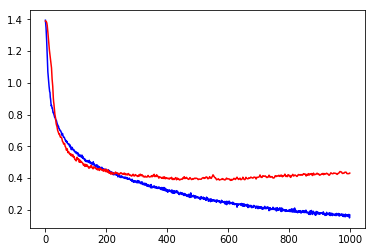

In [25]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
valid_loss_min = np.Inf
epochs = 1000
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    tr_accuracy = 0
    for images, labels in trainloader:
        scheduler.step()
        images = images.cuda()
        labels = labels.long().cuda().reshape(-1)
        optimizer.zero_grad()
        
        log_ps  = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        tr_accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images = images.cuda()
                labels = labels.long().cuda().reshape(-1)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{} ".format(e+1, epochs),
              "Training Loss: {:.3f} ".format(train_losses[-1]),
              "Training Acc: {:.3f} ".format(tr_accuracy/len(trainloader)),
              "Test Loss: {:.3f} ".format(test_losses[-1]),
              "Test Acc: {:.3f}".format(accuracy/len(testloader)))
        if test_loss/len(testloader) <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          test_loss/len(testloader)))
          torch.save(model.state_dict(), 'best_model.pt')
          valid_loss_min = test_loss/len(testloader)
        
plt.plot(train_losses, 'b', label='Training Loss')
plt.plot(test_losses, 'r', label='Validation Loss')
plt.show()

# Test 

In [26]:
import torch
import torch.utils.data as utils

test_tensor_x = torch.stack([transform(torch.Tensor(i)) for i in test_img]) 


test_data = utils.TensorDataset(test_tensor_x)
testingloader = utils.DataLoader(test_data, batch_size = 2000)





with torch.no_grad():
  model.eval()
  for [images] in testingloader:
      images = images.cuda()
      log_ps = model(images)
      ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(1, dim=1)


preds = top_class.cpu().numpy().reshape(-1)
preds.shape

(2000,)

In [0]:
preds[preds == 1] = 2
preds[preds == 2] = 3
preds[preds == 3] = 6

In [0]:
list(np.arange(len(preds)))[-1]

1999

# Test to df

In [28]:
df = pd.DataFrame({'image_index': list(np.arange(len(preds))) ,'class': list(preds.reshape(-1))})
df.head()

,class,image_index
0,6,0
1,6,1
2,6,2
3,6,3
4,6,4


In [0]:
df.to_csv('cv_test_submission.csv', index=False)

In [29]:
df

,class,image_index
0,6,0
1,6,1
2,6,2
3,6,3
4,6,4
5,6,5
6,6,6
7,0,7
8,6,8
9,6,9
